# Combining models 
This file contains sample implementaion of combining our trained models

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Dropout, Rescaling
from tensorflow.keras.layers import Layer
from keras.layers import BatchNormalization, LayerNormalization, Add, MultiHeadAttention
from PIL import Image
import numpy as np

## We created our own layer
We created BoundingBoxCropLayer.     
It crops the image with some margin to generated mask, recalculates pixels so they are 0 below the treshold and 1 above it. It also rescales cropped image to 64x64 pixels.   
If the mask failed to generate, the model still works and sends some information outside of it.

In [2]:
info = ["mask", True]
def show_image(image):
    image_array = np.array(image[0] * 255).squeeze()
    info[0] = Image.fromarray(image_array.astype(np.uint8))
    
def mask_exist():
    info[1] = True

def mask_not_exist():
    info[1] = False

@tf.function
def boundingBox(t):
    info[1] = False
    margin = 2
    ymin = tf.constant(0, dtype=tf.int64)
    xmin = tf.constant(0, dtype=tf.int64)
    ymax = tf.constant(127, dtype=tf.int64)
    xmax = tf.constant(127, dtype=tf.int64)
    tf.py_function(mask_not_exist,[],[])
    if tf.shape(t)[0] > 0:
        ymin = tf.maximum(tf.reduce_min(t[:, 1]) - margin, 0)
        xmin = tf.maximum(tf.reduce_min(t[:, 2]) - margin, 0)
        ymax = tf.minimum(tf.reduce_max(t[:, 1]) + margin, 127)
        xmax = tf.minimum(tf.reduce_max(t[:, 2]) + margin, 127)
        tf.py_function(mask_exist, [], [])
    return ymin, xmin, ymax, xmax

class BoundingBoxCropLayer(layers.Layer):
    def __init__(self, target_size=(64, 64)):
        super(BoundingBoxCropLayer, self).__init__()
        self.target_size = target_size

    def call(self, inputs):
        gray_image = inputs 
        gray_image = tf.where(gray_image > 0.5, 1.0, 0.0) 
        non_zero_pixels = tf.where(gray_image != 0)

        ymin, xmin, ymax, xmax = boundingBox(non_zero_pixels)

        # cropping
        cropped_image = gray_image[:, ymin:ymax, xmin:xmax, :]  
        # resizing
        resized_image = tf.image.resize(cropped_image, self.target_size)
        # showcasing
        tf.py_function(show_image, [resized_image], [])
        
        return resized_image
    def compute_output_shape(self, input_shape):
        # Output shape is based on the target size after resizing
        return (input_shape[0], self.target_size[0], self.target_size[1], input_shape[-1])

## Connecting the models

In [3]:
def attention_block(x):
    query = Dense(x.shape[-1])(x)
    key = Dense(x.shape[-1])(x)
    value = Dense(x.shape[-1])(x)
    attention_output = MultiHeadAttention(num_heads=3, key_dim=x.shape[-1])(query, key, value)
    attention_output = Add()([x, attention_output])  # Residual connection
    attention_output = LayerNormalization()(attention_output)
    return attention_output

input_layer1 = Input(shape=(128,128,3,))

# Encoder
down_conv_1 = Conv2D(32, kernel_size = (3, 3), activation='relu', padding='same')(input_layer1)
down_conv_1 = Conv2D(32, kernel_size = (3, 3), activation='relu', padding='same')(down_conv_1)
max_pool_1 = MaxPooling2D(pool_size=(2, 2))(down_conv_1)

down_conv_2 = Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same')(max_pool_1)
down_conv_2 = Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same')(down_conv_2)
max_pool_2 = MaxPooling2D(pool_size=(2, 2))(down_conv_2)

down_conv_3 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding='same')(max_pool_2)
down_conv_3 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding='same')(down_conv_3)
max_pool_3 = MaxPooling2D(pool_size=(2, 2))(down_conv_3)

# Bottleneck
down_conv_4 = Conv2D(256, kernel_size = (3, 3), activation='relu', padding='same')(max_pool_3)
down_conv_4 = Conv2D(256, kernel_size = (3, 3), activation='relu', padding='same')(down_conv_4)

# Decoder
up_sample_1 = UpSampling2D(size=(2, 2))(down_conv_4)
concat_1 = concatenate([down_conv_3, up_sample_1], axis=-1)
up_conv_1 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding='same')(concat_1)
up_conv_1 = Conv2D(128, kernel_size = (3, 3), activation='relu', padding='same')(up_conv_1)

up_sample_2 = UpSampling2D(size=(2, 2))(up_conv_1)
concat_2 = concatenate([down_conv_2, up_sample_2], axis=-1)
up_conv_2 = Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same')(concat_2)
up_conv_2 = Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same')(up_conv_2)

up_sample_3 = UpSampling2D(size=(2, 2))(up_conv_2)
concat_3 = concatenate([down_conv_1, up_sample_3], axis=-1)
up_conv_3 = Conv2D(32, kernel_size = (3, 3), activation='relu', padding='same')(concat_3)
up_conv_3 = Conv2D(32, kernel_size = (3, 3), activation='relu', padding='same')(up_conv_3)

output_layer1 = Conv2D(1, (1, 1), activation='sigmoid')(up_conv_3)
model1 = Model(inputs=[input_layer1], outputs=[output_layer1])
model1.trainable = False
model1.compile(optimizer='adam', loss='binary_crossentropy')


#####################################################
############### CONNECTING MODELS ###################
cropped_output = BoundingBoxCropLayer()(output_layer1)
#####################################################

input_layer2 = Input(shape=(64, 64, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer2)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = attention_block(x)

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)

output_layer2 = Dense(6, activation='softmax')(x)
model2 = Model(inputs=[input_layer2], outputs=[output_layer2])
model2.trainable = False
model2.compile(loss='categorical_crossentropy', optimizer='adam')


final_output = model2(cropped_output)
combined_model = Model(inputs=[input_layer1], outputs=[final_output])

combined_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.load_weights("D:\\Zadania\\frei18.weights.h5")
model2.load_weights("D:\\Zadania\\FingerDigits\\fingerNumbers.weights.h5")

D:\Users\crash\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Results

D:\Users\crash\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
D:\Users\crash\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


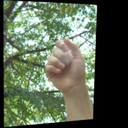

I think this is  0
basing on predicted mask: 


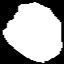

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


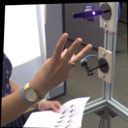

I think this is  3
basing on predicted mask: 


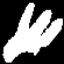

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


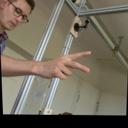

I think this is  2
basing on predicted mask: 


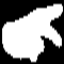

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


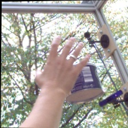

I think this is  4
basing on predicted mask: 


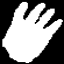

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


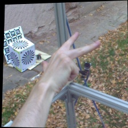

I think this is  2
basing on predicted mask: 


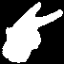

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


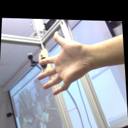

I think this is  5
basing on predicted mask: 


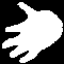

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


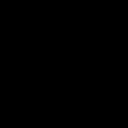

Either we couldn't find a hand on the image or there is no hand on the image :(


In [4]:
import os
for t in os.listdir("tests"):
    testImg = Image.open(f"tests\\{t}").resize((128, 128))
    test = np.array([testImg])/255
    info[1] = True
    prediction = combined_model.predict(test)
    display(testImg)
    if info[1]:
        print("I think this is ", np.argmax(prediction[0]))
        print("basing on predicted mask: ")
        display(info[0])
    else:
        print("Either we couldn't find a hand on the image or there is no hand on the image :(")